<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Session14_RCNN%26DenseDepth/dataCreation_bg_fg_mask_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Tue May 12 14:30:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Import packages

In [0]:
import cv2
import os
from google.colab.patches import cv2_imshow
from skimage import io
import glob
import random
import numpy as np
from tqdm.autonotebook import tqdm, trange
import time
import shutil
import matplotlib.pyplot as plt
from PIL import Image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [0]:
# Configuring paths
# Raw background images containing square images.
raw_bg = './raw_bg'
# Raw foreground images
raw_fg = './raw_fg'
# 200 * 200 size background images
bg_images = './bg'
# Foreground images.
fg_images = './fg'
# Background with foreground images.
bg_fg_images = './bg_fg'
# Mask images.
mask_images = './mask'
# Monocular depth images.
depth_images = './depth'

# Foreground images resize height.
desired_h = 80
# Flag for colour/grayscale bg_fg images.
colour_flag = True

# DenseDepth. 
# batch size of the stacked image set.
depth_batch_size = 384
# Model's processing batch size
model_batch_size = 64

gdrive_path = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

## Resizing images to desired resolutions.

Resizing square background images to desired resolution. Raw images are present on the mounted drive. 
Background image is resized to 192*192 and foreground image is resized to fixed height of 80 while keeping the aspect ratio. 

In [0]:
# To resize background and foreground images the first time, go to mounted drive. 
cd '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth


In [0]:
!ls '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

bg				     DenseDepth		      raw_bg
bg_fg				     depth		      raw_fg
dataCreation-bg_fg_mask_depth.ipynb  fg			      results
DataCreation-bg_fg_mask_depth.ipynb  ImagePreparation.gsheet
DataViz.ipynb			     mask


In [0]:
# Resize square images to 192 * 192 images for background.
paths = glob.glob(os.path.join(raw_bg,'*'))
paths.sort()
for path in paths:
    img = cv2.imread(path)
    file_name = path.split('/')[-1] 
    resized_img = cv2.resize(img, (192, 192), interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(bg_images,file_name), resized_img)

In [0]:
ls bg | wc -l

100


Resizing foreground to required height keeping aspect ratio constant.

In [0]:
paths = glob.glob(os.path.join(raw_fg,'*'))
paths.sort()

for path in paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    file_name = path.split('/')[-1]
    h, w = img.shape[:2]
    r = desired_h/float(h)
    dim = (int(w * r), desired_h)
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(fg_images,file_name), resized_img)

 ## Background and foreground image display.

In [0]:
def display_horizontal(img_paths, img_name):
    # img = []
    # horizontal_concat = []
    it = 0
    margin = 8
    for img_path in img_paths:
        if it == 0:
            img = cv2.imread(img_path)
            horizontal_concat = np.hstack((img, np.ones((img.shape[0], margin, img.shape[2]))*255))
        else:           
            img = cv2.imread(img_path)
            horizontal_concat = np.hstack((horizontal_concat,img, np.ones((img.shape[0], margin, img.shape[2]))*255))
            # horizontal_concat = np.concatenate((horizontal_concat,img), axis = 1)
        it +=1
    cv2_imshow(horizontal_concat)
    cv2.imwrite(os.path.join(gdrive_path,'results',img_name+'.jpg'), horizontal_concat)

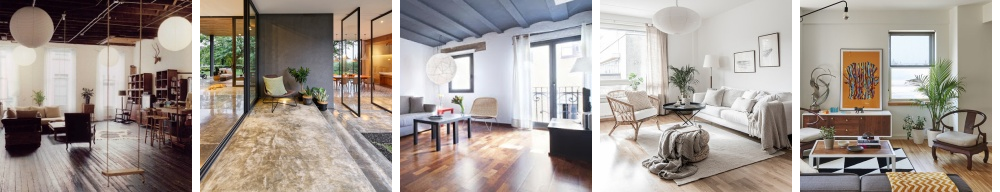

In [0]:
bg_im = glob.glob(os.path.join(bg_images,'*'))
display_horizontal(bg_im[:5], "background_images")

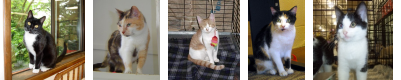

In [0]:
fg_im = glob.glob(os.path.join(fg_images,'*'))
display_horizontal(fg_im[:5], "foreground_images")

## bg_fg and Mask creation

Move to local directory and copy bg and fg folders to local.

In [0]:
pwd

'/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

In [0]:
cd /content

/content


In [0]:
ls

bg/  bg_fg/  fg/  mask/  sample_data/


In [0]:
fg_dir = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/fg'
shutil.copytree(fg_dir,"fg")

'fg'

In [0]:
bg_dir = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/bg'
shutil.copytree(bg_dir,"bg")

'bg'

In [0]:
if os.path.exists("bg_fg"):
    shutil.rmtree("bg_fg")
if os.path.exists("mask"):
    shutil.rmtree("mask")

os.mkdir("bg_fg")
os.mkdir("mask")


In [0]:
ls

bg/  bg_fg/  fg/  mask/  sample_data/


In [0]:
bg_paths = glob.glob(os.path.join(bg_images,'*'))
fg_paths = glob.glob(os.path.join(fg_images,'*'))

# Sort bg and fg paths in ascending order to keep created bgfg and mask images in order.
bg_paths.sort()
fg_paths.sort()

# For each background image, prepare bg_fg and mask
# for bg_no, bg_path in enumerate(tqdm(bg_paths, 1)):
for bg_no, bg_path in tqdm(enumerate(bg_paths, 1), total = len(bg_paths), desc = 'Background Images'):
    background = cv2.imread(bg_path)
    bg_height, bg_width, bg_channels = background.shape
    
    # For each foreground image, prepare bg_fg and mask
    for fg_no, fg_path in tqdm(enumerate(fg_paths, 1), total = len(fg_paths), desc = 'Foreground Images', leave=False):
        # Read png image with transparency alpha channel as well.
        foreground_ = cv2.imread(fg_path, cv2.IMREAD_UNCHANGED)
        fg_height, fg_width, fg_channels = foreground_.shape
        i = 0

        # For each of normal and flipped foreground image, prepare fg_bg and mask
        for foreground in (foreground_, cv2.flip(foreground_, 1)):
            # alpha = 0 represents full transparency and max value indicates opaqueness.
            alpha_foreground = foreground[:,:,3] / 255.0
            alpha_background = 1 - alpha_foreground
            for j in range(0, 20):
                # For image overlay
                
                x_offset = random.randint(0, (bg_width - fg_width))
                y_offset = random.randint(0, (bg_height - fg_height))
                
                y1, y2 = y_offset, y_offset + fg_height
                x1, x2 = x_offset, x_offset + fg_width

                # For overlay
                overlay = background.copy()

                # For mask
                mask = np.zeros(background[:,:,0].shape)
                mask_fg = cv2.cvtColor(foreground[:,:,:3], cv2.COLOR_BGR2GRAY)
                mask_fg[:] = 255
                
                for c in range(0,3):    
                    overlay[y1:y2, x1:x2, c] = (alpha_foreground * foreground[:, :, c] + alpha_background * background[y1:y2, x1:x2, c])
                
                mask[y1:y2, x1:x2] = (alpha_foreground * mask_fg[:, :] + alpha_background * mask[y1:y2, x1:x2])
                
                if colour_flag:
                    # cv2.imwrite(os.path.join(bg_fg_images,"bgfg_b"+str(bg_no)+"_f"+str(fg_no)+"_"+str(i)+".jpg"), overlay)
                    cv2.imwrite(os.path.join(bg_fg_images,"bgfg_b"+str(bg_no).zfill(3)+"_f"+str(fg_no).zfill(3)+"_"+str(i)+".jpg"), overlay)
                else:
                    cv2.imwrite(os.path.join(bg_fg_images,"bgfg_b"+str(bg_no).zfill(3)+"_f"+str(fg_no).zfill(3)+"_"+str(i)+".jpg"), cv2.cvtColor(overlay[:,:,:3], cv2.COLOR_BGR2GRAY))
                
                cv2.imwrite(os.path.join(mask_images,"mask_b"+str(bg_no).zfill(3)+"_f"+str(fg_no).zfill(3)+"_"+str(i)+".jpg"), mask)
                i += 1
            


## Display Overlayed images and its mask

Lets see the prepared overlayed bg_fg and mask images.

In [0]:
bg_fg_paths = glob.glob(os.path.join(bg_fg_images,'*'))
bg_fg_paths.sort()
mask_paths = glob.glob(os.path.join(mask_images,'*'))
mask_paths.sort()

Overlayed bg_fg images.

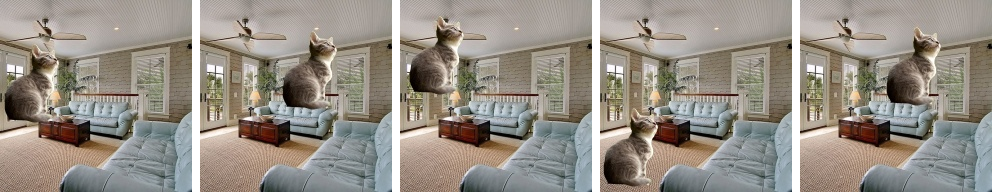

In [0]:
display_horizontal(bg_fg_paths[:5], "Overlayed_images")

Mask Images

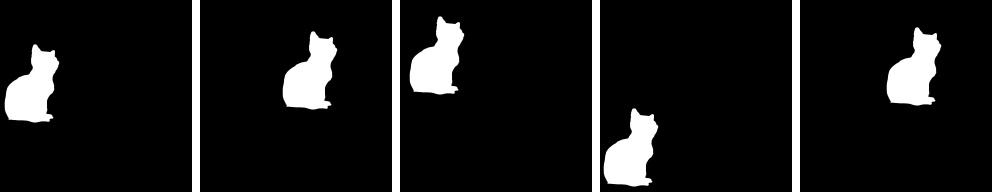

In [0]:
display_horizontal(mask_paths[:5], "Mask_images")

## Move bg_fg and mask to network drive

In [0]:
ls bg_fg | wc -l

400000


In [0]:
ls

bg/  bg_fg/  fg/  mask/  sample_data/


In [0]:
!pwd

/content


In [0]:
!zip -r -q bg_fg.zip bg_fg/

In [0]:
shutil.move("bg_fg.zip", gdrive_path)

'/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/bg_fg.zip'

In [0]:
!zip -r -q mask.zip mask/

In [0]:
shutil.move("mask.zip", gdrive_path)

'/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/mask.zip'

## Create Depth Images

In [0]:
cd '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

/gdrive/.shortcut-targets-by-id/1M2uhN0xfPzwzD-vM60_7x20OVsZMnlRt/Mask_RCNN_depth


In [0]:
# Import necessary packages
import os
import glob
import argparse
import matplotlib
import numpy as np
from PIL import Image
from skimage.transform import resize

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict, load_images, display_images
from matplotlib import pyplot as plt

denseDepth_model = 'DenseDepth/nyu.h5'

custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')
# Load model into GPU / CPU
model = load_model(denseDepth_model, custom_objects=custom_objects, compile=False)
print('\nModel loaded ({0}).'.format(denseDepth_model))

Using TensorFlow backend.


Loading model...

Model loaded (DenseDepth/nyu.h5).


In [0]:
cd /content

/content


In [0]:
ls

bg_fg/  bg_fg.zip  sample_data/


## If bg_fg is already created

Copy data from gdrive and process.

In [0]:
pwd

'/content'

In [0]:
bg_fg_dir = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/bg_fg.zip'
shutil.copy(bg_fg_dir,os.getcwd())

'/content/bg_fg.zip'

In [0]:
!unzip -q bg_fg.zip

In [0]:
ls bg_fg | wc -l

400000


## Create depth images folder

In [0]:
# Remove old depth folder, if present.
if os.path.exists("depth"):
    shutil.rmtree("depth")

In [0]:
os.mkdir("depth")

In [0]:
ls

bg_fg/  bg_fg.zip  depth/  sample_data/


## Depth calculation begins

In [0]:
pwd

'/content'

In [0]:
bg_fg_paths = glob.glob(os.path.join(bg_fg_images,'*'))
bg_fg_paths.sort()
print(len(bg_fg_paths))
# bg_fg_paths = bg_fg_paths[0:2200]
print(len(bg_fg_paths),"first file-", bg_fg_paths[0], "Last File-",bg_fg_paths[-1])

400000
400000 first file- ./bg_fg/bgfg_b001_f001_0.jpg Last File- ./bg_fg/bgfg_b100_f100_9.jpg


In [0]:
pbar = trange(0, len(bg_fg_paths), depth_batch_size)
for depth_image_id in pbar:
    # Take only batch size worth of bg_fg images.
    loaded_images = []
    bgfg_filename = []

    read_tic = time.time()
    for file in bg_fg_paths[depth_image_id: (depth_image_id + depth_batch_size)]:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        x = resize(x, (384,384), Image.ANTIALIAS)
        loaded_images.append(x)
        bgfg_filename.append(file.split("bgfg")[-1])
    inputs = np.stack(loaded_images, axis=0)
    read_toc = time.time()

    model_tic = time.time()
    # Dense Depth prediction
    outputs = predict(model, inputs, batch_size=model_batch_size)
    model_toc = time.time()

    write_tic=time.time()
    for idx, output in enumerate(outputs):
        # output_img = Image.fromarray((output[:, :, 0] * 255).astype(np.uint8))
        rescaled = (output[:, :, 0])
        rescaled = rescaled - np.min(rescaled)
        rescaled = rescaled / np.max(rescaled)
        output_img = Image.fromarray((rescaled * 255).astype(np.uint8))
        output_img.save(os.path.join(depth_images,"densedepth"+bgfg_filename[idx]))
    write_toc = time.time()

    pbar_details = f'R={(read_toc-read_tic):0.2f} s - P={(model_toc-model_tic):0.2f} s - W={(write_toc-write_tic):0.2f} s'
    pbar.set_description(desc= pbar_details)



## Depth image display

In [0]:
depth_paths = glob.glob(os.path.join(depth_images,'*'))
depth_paths.sort()
print(len(depth_paths),"first file-", depth_paths[0], "Last File-",depth_paths[-1])

400000 first file- ./depth/densedepth_b001_f001_0.jpg Last File- ./depth/densedepth_b100_f100_9.jpg


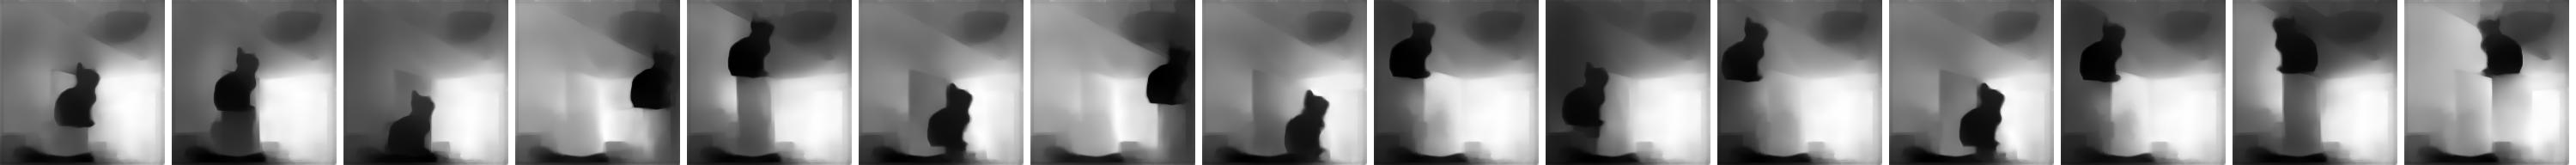

In [0]:
display_horizontal(depth_paths[120000:120015], "Depth_images1")

## Move data to mounted drive.

In [0]:
ls

bg_fg/  bg_fg.zip  depth/  sample_data/


In [0]:
!zip -r -q depth.zip depth/

In [0]:
shutil.move("depth.zip", gdrive_path)

'/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/depth.zip'

## Display Overlayed, mask and depth images.

In [0]:
# To generate random images, lets take random indices between 0 to 2000.
rand_idx = [random.randint(0,2000) for i in range(5)]
print(random.randint(0,2000))
print(rand_idx)

ov_img = []
ma_img = []
de_img = []
for z in rand_idx:
    ov_img.append(bg_fg_paths[z])
    ma_img.append(mask_paths[z])
    de_img.append(depth_paths[z])



149
[1003, 461, 153, 1630, 1566]


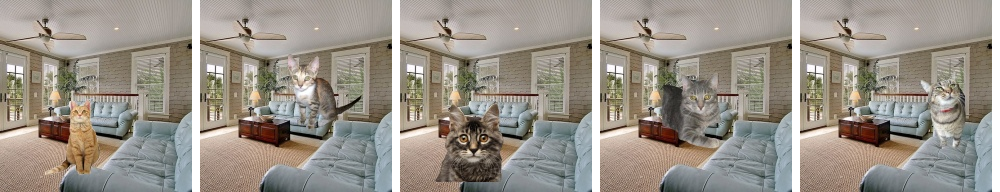

In [0]:
display_horizontal(ov_img, "Overlayed_images1")

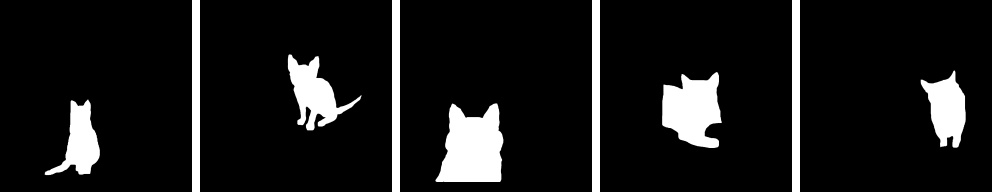

In [0]:
display_horizontal(ma_img, "Mask_images1")

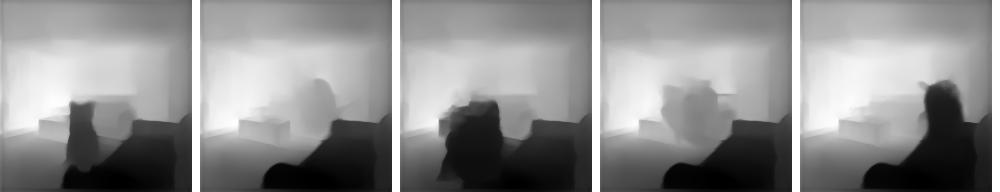

In [0]:
display_horizontal(de_img, "Depth_images1")

# THE END